In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой будет вестись работа в проекте

In [2]:
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-analyst-advanced-sql'
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [4]:
# запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       SUM(views_count) AS posts
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY CAST(DATE_TRUNC('month', creation_date) AS date)
ORDER BY posts DESC;
'''

df = pd.read_sql_query(query, con=engine) # выполнение запроса
df

,month,posts
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

<div class="alert alert-info">
    <b> Ответ </b>

    Значительно меньше постов в июле и августе 2008 года, чем в последующие месяцы. Летом люди в основном
    отдыхают от учёбы/работы, а осенью начинают создавать посты с вопросами, в сентябре постов больше всего.
    
</div>

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [5]:
query = '''
SELECT u.display_name,
       COUNT(DISTINCT u.id)
FROM stackoverflow.posts p
JOIN stackoverflow.post_types pt ON pt.id = p.post_type_id
JOIN stackoverflow.users u ON u.id = p.user_id
WHERE pt.type = 'Answer' AND p.creation_date <= (u.creation_date + INTERVAL '1 month')
GROUP BY u.display_name
HAVING COUNT(pt.type) > 100
ORDER BY u.display_name;
'''

df = pd.read_sql_query(query, con=engine)
df.head(20)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
5,Amy B,1
6,Ben Hoffstein,1
7,Brian,15
8,Cade Roux,1
9,CesarB,1


Какие аномалии наблюдаются в данных? О чём они говорят?

<div class="alert alert-info">
    <b> Ответ </b>

    Заметно, что в некоторых случаях одному имени пользователя соответствуют несколько уникальных id пользователя.
    Взглянув на имена пользователей, становится ясно, что это обычные имена, которые задали себе разные пользователи,
    т.е. такой никнейм достаточно легко придумать, ведь он повторяет имя человека.
    
</div>

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [6]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       COUNT(*)
FROM stackoverflow.posts
WHERE user_id IN
    (SELECT DISTINCT u.id
     FROM stackoverflow.users u
     JOIN stackoverflow.posts p ON u.id = p.user_id
     WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01'
       AND DATE_TRUNC('month', p.creation_date) = '2008-12-01')
GROUP BY month
ORDER BY month DESC;
'''

df = pd.read_sql_query(query, con=engine)
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

<div class="alert alert-info">
    <b> Ответ </b>

    Имеется 32 поста, созданных в августе 2008 года, но их авторы при этом были зарегистрированы в сентябре. Возможно,
    это ошибки в записи данных о регистрации. Могу также предположить, что эти пользователи могли делать посты
    без регистрации. 
    
</div>

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [7]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date ASC;
'''

df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [8]:
query = '''
WITH users AS
    (SELECT user_id,
            DATE_TRUNC('day', creation_date)::date AS day,
            COUNT(id) AS count_posts
     FROM stackoverflow.posts
     WHERE user_id IN
         (SELECT user_id       
          FROM stackoverflow.posts
          WHERE DATE_TRUNC('month', creation_date)::date  = '2008-08-01'
          GROUP BY 1
          HAVING COUNT(id) > 120) AND DATE_TRUNC ('month', creation_date)::date = '2008-08-01'
    GROUP BY 1,
             2
    ORDER BY day DESC)
SELECT user_id,
       AVG(count_posts) AS avg_daily
FROM users
GROUP BY user_id
ORDER BY avg_daily;
'''

df = pd.read_sql_query(query, con=engine)
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [9]:
query = '''
WITH tab AS 
(SELECT DISTINCT user_id,
        COUNT (DISTINCT p.creation_date :: date) AS active_days
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY p.user_id)
SELECT ROUND(AVG(tab.active_days)) AS result
FROM tab;
'''

df = pd.read_sql_query(query, con=engine)
df

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

<div class="alert alert-info">
    <b> Ответ </b>

    В среднем в период с 1 по 7 декабря 2008 года каждый пользователь имел два активных дня.
     
</div>

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [10]:
query = '''
SELECT user_id,
       creation_date,
       TO_CHAR(prelast_date, 'Month') as prelast_month
FROM
(WITH tab AS
(SELECT user_id,
        creation_date 
FROM stackoverflow.posts
GROUP BY user_id, creation_date
ORDER BY user_id, creation_date)
SELECT user_id,
       creation_date,
       LAG(DATE_TRUNC('month', creation_date)::date, 2, null ) OVER (PARTITION BY user_id ORDER BY creation_date ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS prelast_date
FROM tab) AS tab_2
'''

df = pd.read_sql_query(query, con=engine)
df.head(10)

,user_id,creation_date,prelast_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [11]:
query = '''
WITH profile AS
  (SELECT id AS user_id,
          DATE_TRUNC('month', T.start_dt) AS dt,
          COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', T.start_dt)) AS cohort_users_cnt
   FROM
     (SELECT u1.id,
             DATE_TRUNC('month', p1.creation_date) AS creation_date,
             MIN(p1.creation_date) OVER (PARTITION BY u1.id
                                         ORDER BY p1.creation_date) AS start_dt
      FROM stackoverflow.users u1
      JOIN stackoverflow.posts p1 ON u1.id = p1.user_id) T
   GROUP BY id,
            dt),
sessions AS
  (SELECT user_id,
          DATE_TRUNC('month', creation_date) AS session_date
   FROM stackoverflow.posts
   GROUP BY user_id,
            session_date)
SELECT p.dt AS cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4;
'''

df = pd.read_sql_query(query, con=engine)
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

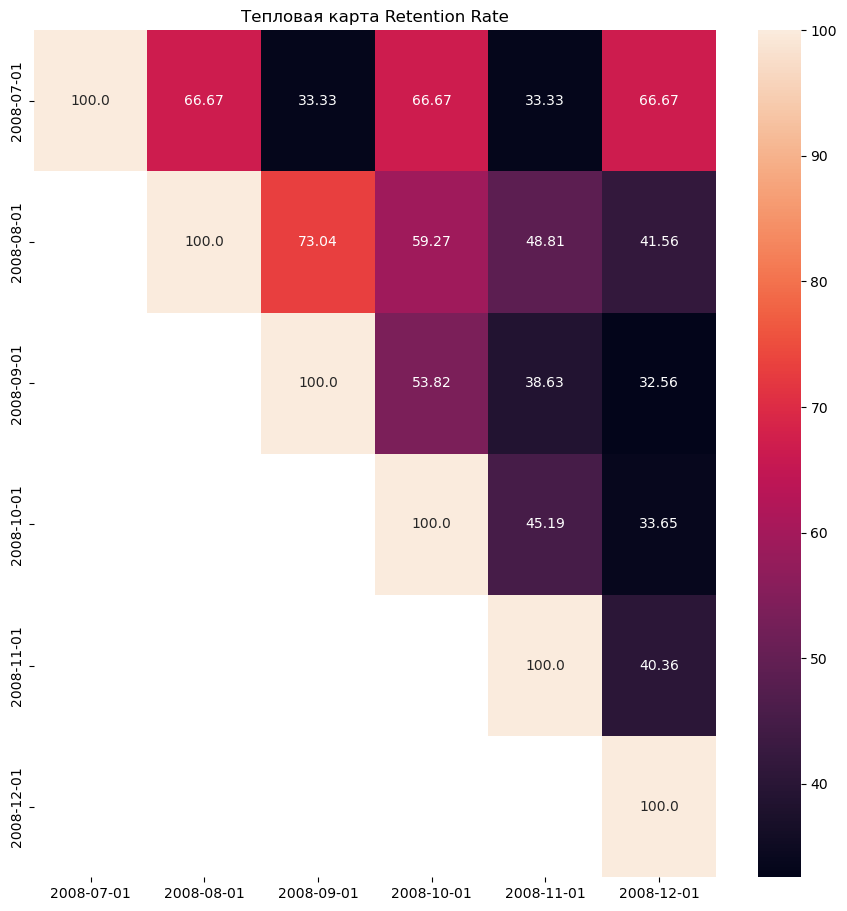

In [12]:
import seaborn as sns
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(11, 11))
sns.heatmap(retention, annot=True, fmt='')
plt.title('Тепловая карта Retention Rate')
plt.show() 

<div class="alert alert-info">
    <b> Ответ </b>

    - В когорте августа самый большой показатель Retention Rate за первый месяц. Также высокий показатель RR за первый 
    месяц у когорт июля (67%) и сентября (54%).
      
    - В когорте июля RR повторяется через месяц - в нечетные по 67%, в четные по 33,33% - выглядит неестественно.
    Такие показатели из-за того, что в этой когорте было очень мало пользователей.
    
    - RR падает сильнее всего в когорте сентября.
     
</div>

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [13]:
query = '''
SELECT creation_month,
       posts_count,
       ROUND((posts_count - prev_month_posts_count)::numeric * 100 / prev_month_posts_count, 2) AS percentage
FROM
(SELECT *,
       LAG(posts_count) OVER (ORDER BY posts_count DESC) AS prev_month_posts_count    
FROM
(SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
       COUNT (id) AS posts_count
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31' 
GROUP BY creation_month) AS tab) AS tab_2
'''

df = pd.read_sql_query(query, con=engine)
df

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

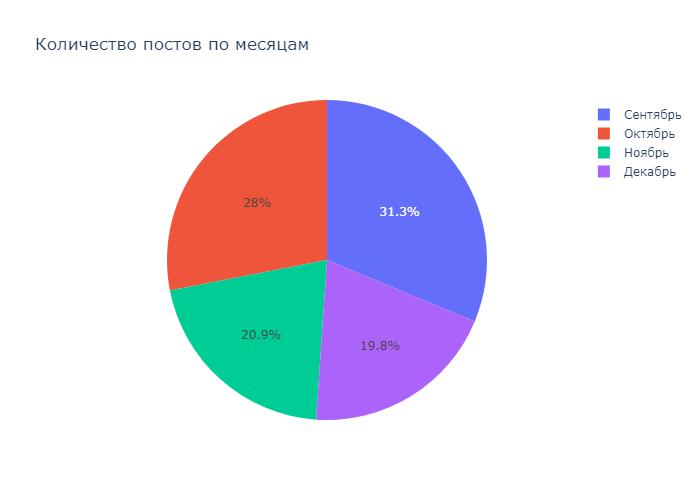

In [14]:
import warnings
warnings.filterwarnings('ignore')

from plotly import graph_objects as go
fig = go.Figure(data=[go.Pie(labels=df['creation_month'], values=df['posts_count'])])
fig.update_layout(title='Количество постов по месяцам')
for trace in fig.data:
    trace['labels']=['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
fig.show('png')

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [15]:
query = '''
SELECT DISTINCT week_creation::int,
       MAX(creation_date) OVER (ORDER BY week_creation) AS creation_date
FROM       
(SELECT EXTRACT(WEEK FROM creation_date) AS week_creation,
        creation_date
FROM stackoverflow.posts
WHERE user_id IN 
(
SELECT id AS user_id
FROM 
(SELECT DISTINCT u.id,
        COUNT(p.id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
GROUP BY u.id
ORDER BY count DESC
LIMIT 1) AS tab)
) AS tab_2
WHERE creation_date::date BETWEEN '2008-10-01' AND '2008-10-31';
'''

df = pd.read_sql_query(query, con=engine)
df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
